******# Introduction

In [1]:
!pip install rdkit torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from rdkit import Chem
import pandas as pd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 46.6 MB/s eta 0:00:00:00:0100:01


In [2]:
def load_qm9_dataset(url: str = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv") -> pd.DataFrame:
    """
    Download and load the QM9 dataset.

    This function downloads the QM9 dataset from the specified URL using wget,
    then loads it into a pandas DataFrame. It extracts the SMILES strings
    from the DataFrame for further processing.

    Args:
        url (str): The URL of the QM9 dataset CSV file.
                   Defaults to the DeepChem hosted QM9 dataset.

    Returns:
        pd.DataFrame: The loaded QM9 dataset as a pandas DataFrame.

    Raises:
        subprocess.CalledProcessError: If the wget command fails.
        pd.errors.EmptyDataError: If the CSV file is empty or cannot be read.

    Note:
        This function requires wget to be installed and accessible in the system path.
        It saves the downloaded file as 'qm9.csv' in the current directory.
    """
    import subprocess

    # Download the QM9 dataset
    try:
        subprocess.run(['wget', url], check=True)
        print(f"Dataset downloaded successfully from {url}")
    except subprocess.CalledProcessError as e:
        print(f"Failed to download dataset: {e}")
        raise

    # Load the dataset
    try:
        df = pd.read_csv('qm9.csv')
        print(f"Loaded QM9 dataset with {len(df)} entries")
        return df
    except pd.errors.EmptyDataError:
        print("The CSV file is empty or could not be read")
        raise

# go
df = load_qm9_dataset()
smiles_list = df['smiles'].tolist()
print(f"Extracted {len(smiles_list)} SMILES strings from the dataset")

--2024-11-11 15:47:30--  https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv
Resolving deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)... 52.219.121.114, 52.219.193.122, 3.5.163.155, ...
Connecting to deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)|52.219.121.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29856825 (28M) [text/csv]
Saving to: 'qm9.csv'

     0K .......... .......... .......... .......... ..........  0% 2.09M 14s
    50K .......... .......... .......... .......... ..........  0% 2.09M 14s
   100K .......... .......... .......... .......... ..........  0% 2.08M 14s
   150K .......... .......... .......... .......... ..........  0%  109M 10s
   200K .......... .......... .......... .......... ..........  0% 2.17M 11s
   250K .......... .......... .......... .......... ..........  1%  147M 9s
   300K .......... .......... .......... .......... ..........  1%  137M

Dataset downloaded successfully from https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv
Loaded QM9 dataset with 133885 entries
Extracted 133885 SMILES strings from the dataset


In [ ]:
from typing import List, Dict

def create_vocabulary(smiles_list: List[str]) -> Dict[str, int]:
    vocab = {'<': 0, '>': 1}  # Start and end tokens
    for smiles in smiles_list:
        for char in smiles:
            if char not in vocab:
                vocab[char] = len(vocab)
    return vocab

vocab = create_vocabulary(smiles_list)

In [4]:
class SMILESDataset(Dataset):
    """
    A PyTorch Dataset for SMILES strings.

    This dataset converts SMILES strings into one-hot encoded tensors based on a given vocabulary.
    It adds start ('<') and end ('>') tokens to each SMILES string before encoding.

    Attributes:
        smiles_list (List[str]): A list of SMILES strings.
        vocab (Dict[str, int]): A dictionary mapping characters to their corresponding indices.
        vocab_size (int): The size of the vocabulary.

    """

    def __init__(self, smiles_list: List[str], vocab: Dict[str, int], max_length: int = 100):
        """
        Initialize the SMILESDataset.

        Args:
            smiles_list (List[str]): A list of SMILES strings to be encoded.
            vocab (Dict[str, int]): A dictionary mapping characters to their corresponding indices.
        """
        self.smiles_list = smiles_list
        self.vocab = vocab
        self.vocab_size = len(vocab)
        self.max_length = max_length

    def __len__(self) -> int:
        """
        Get the number of items in the dataset.

        Returns:
            int: The number of SMILES strings in the dataset.
        """
        return len(self.smiles_list)

    def __getitem__(self, idx: int) -> torch.Tensor:
        """
        Get a one-hot encoded tensor for a SMILES string at the given index.

        Args:
            idx (int): The index of the SMILES string to retrieve.

        Returns:
            torch.Tensor: A one-hot encoded tensor representing the SMILES string.
                          Shape: (len(smiles), vocab_size)

        Note:
            Start ('<') and end ('>') tokens are added to the SMILES string before encoding.
            If a character in the SMILES string is not in the vocabulary, it is encoded as the first token (index 0).
        """

        smiles = '<' + self.smiles_list[idx] + '>'
        encoded = torch.zeros(self.max_length, self.vocab_size)
        for i, c in enumerate(smiles[:self.max_length]):
            encoded[i, self.vocab.get(c, 0)] = 1
        return encoded

In [ ]:
class VAE(nn.Module):

    def __init__(self, vocab_size: int, hidden_dim: int, latent_dim: int):
    
        super(VAE, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        self.encoder = nn.GRU(vocab_size, hidden_dim, batch_first=True)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        self.decoder = nn.GRU(vocab_size + latent_dim, hidden_dim, batch_first=True)
        self.fc_output = nn.Linear(hidden_dim, vocab_size)

    def encode(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    
        _, h = self.encoder(x)
        h = h.squeeze(0)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z: torch.Tensor, max_length: int) -> torch.Tensor:
 
        batch_size = z.size(0)
        h = torch.zeros(1, batch_size, self.hidden_dim).to(z.device)
        x = torch.zeros(batch_size, 1, self.vocab_size).to(z.device)
        outputs = []

        for _ in range(max_length):
            z_input = z.unsqueeze(1).repeat(1, 1, 1)
            decoder_input = torch.cat([x, z_input], dim=2)
            output, h = self.decoder(decoder_input, h)
            output = self.fc_output(output)
            outputs.append(output)
            x = torch.softmax(output, dim=-1)

        return torch.cat(outputs, dim=1)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, x.size(1)), mu, logvar

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os

def loss_function(recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
    BCE = nn.functional.binary_cross_entropy_with_logits(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + 0.1 * KLD

def custom_collate(batch):
    return torch.stack(batch)

# Determine the number of workers based on system resources
num_workers = min(2, os.cpu_count() or 1)

# DataLoader setup
batch_size = 128
dataset = SMILESDataset(smiles_list, vocab, max_length=100)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate,
                        num_workers=num_workers, pin_memory=True)

# Model initialization
vocab_size = len(vocab)
hidden_dim = 256
latent_dim = 64

model = VAE(vocab_size, hidden_dim, latent_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Optimizer initialization
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Initialize mixed precision training if CUDA is available
use_amp = torch.cuda.is_available()
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in dataloader:
        batch = batch.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)

        # Use autocast only if CUDA is available
        with torch.cuda.amp.autocast(enabled=use_amp):
            recon_batch, mu, logvar = model(batch)
            loss = loss_function(recon_batch, batch, mu, logvar)

        # Backward pass and optimization with gradient scaling if CUDA is available
        if use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        total_loss += loss.item()

    # Print epoch results
    avg_loss = total_loss / len(dataloader.dataset)
    print(f'Epoch {epoch+1}, Average Loss: {avg_loss:.4f}')

    # Update learning rate
    scheduler.step(avg_loss)

    # Print current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Current learning rate: {current_lr:.6f}')

print("Training complete!")

/tmp/ipykernel_30/2946797000.py:41: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/tmp/ipykernel_30/2946797000.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 1, Average Loss: 101.1343
Current learning rate: 0.001000
Epoch 2, Average Loss: 50.9847
Current learning rate: 0.001000
Epoch 3, Average Loss: 50.0926
Current learning rate: 0.001000
Epoch 4, Average Loss: 46.6369
Current learning rate: 0.001000
Epoch 5, Average Loss: 42.4373
Current learning rate: 0.001000
Epoch 6, Average Loss: 39.9185
Current learning rate: 0.001000
Epoch 7, Average Loss: 37.2713
Current learning rate: 0.001000
Epoch 8, Average Loss: 33.9555
Current learning rate: 0.001000
Epoch 9, Average Loss: 31.1151
Current learning rate: 0.001000
Epoch 10, Average Loss: 28.3252
Current learning rate: 0.001000
Epoch 11, Average Loss: 25.7963
Current learning rate: 0.001000
Epoch 12, Average Loss: 24.3182
Current learning rate: 0.001000
Epoch 13, Average Loss: 22.2418
Current learning rate: 0.001000
Epoch 14, Average Loss: 20.4575
Current learning rate: 0.001000
Epoch 15, Average Loss: 18.7607
Current learning rate: 0.001000
Epoch 16, Average Loss: 17.9769
Current learning

In [7]:
def generate_smiles(model: torch.nn.Module, vocab: Dict[str, int], num_samples: int = 10, max_length: int = 100) -> List[str]:
    """
    Generate SMILES strings using the trained VAE model.

    This function generates a specified number of SMILES strings by sampling from the
    latent space and decoding the samples using the VAE's decoder.

    Args:
        model (torch.nn.Module): The trained VAE model.
        vocab (Dict[str, int]): The vocabulary mapping characters to indices.
        num_samples (int, optional): Number of SMILES strings to generate. Defaults to 10.
        max_length (int, optional): Maximum length of generated SMILES strings. Defaults to 100.

    Returns:
        List[str]: A list of generated SMILES strings.

    Note:
        - The function uses greedy decoding (taking the most probable character at each step).
        - Generation stops when the end token '>' is produced or max_length is reached.
        - Invalid characters (not in vocabulary) are ignored in the output.
    """
    model.eval()  # Set the model to evaluation mode
    inv_vocab = {v: k for k, v in vocab.items()}  # Invert vocabulary for decoding
    generated_smiles = []
    device = next(model.parameters()).device  # Get the device of the model

    with torch.no_grad():  # Disable gradient computation
        for _ in range(num_samples):
            # Sample from the latent space
            z = torch.randn(1, model.latent_dim).to(device)
            x = torch.zeros(1, 1, model.vocab_size).to(device)
            x[0, 0, vocab['<']] = 1  # Start token
            h = torch.zeros(1, 1, model.hidden_dim).to(device)

            smiles = ''
            for _ in range(max_length):
                z_input = z.unsqueeze(1)
                decoder_input = torch.cat([x, z_input], dim=2)
                output, h = model.decoder(decoder_input, h)
                output = model.fc_output(output)

                probs = torch.softmax(output.squeeze(0), dim=-1)
                next_char = torch.multinomial(probs, 1).item()

                if next_char == vocab['>']:  # End token
                    break

                smiles += inv_vocab.get(next_char, '')
                x = torch.zeros(1, 1, model.vocab_size).to(device)
                x[0, 0, next_char] = 1

            generated_smiles.append(smiles)

    return generated_smiles

# Generate and print some SMILES strings
num_samples = 10
generated_smiles = generate_smiles(model, vocab, num_samples=num_samples)
print(f"Generated {num_samples} SMILES strings:")
for i, smiles in enumerate(generated_smiles, 1):
    print(f"{i}. {smiles}")

Generated 10 SMILES strings:
1. <O=C1C=CC(O)=O)C=O
2. <CC1(CC1))C1CO)C1
3. <OC1CC(OCOO)NO
4. <CC1CC1(CO)C1C#C
5. <COC1OC1(O)C1CC1
6. <CCc1c(c(o1)O)
7. <OC1(CCO)C1=O)C=O
8. <CCc1)n(nn1)C#N)NC
9. <CC1NC2CC1(CO)OC
10. <OC1C(C1)CO)CO


In [8]:
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from typing import Tuple, List, Dict

def validate_and_correct_smiles(smiles: str) -> Tuple[bool, str]:
    """
    Validate and attempt to correct a SMILES string.

    Args:
        smiles (str): The SMILES string to validate and correct.

    Returns:
        Tuple[bool, str]: A tuple containing a boolean indicating validity
                          and the corrected SMILES string (or original if invalid).
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        try:
            Chem.SanitizeMol(mol)
            return True, Chem.MolToSmiles(mol, isomericSmiles=True)
        except:
            pass
    return False, smiles

def enhanced_post_process_smiles(smiles: str) -> str:
    """
    Post-process a SMILES string to correct common issues.

    Args:
        smiles (str): The SMILES string to process.

    Returns:
        str: The processed SMILES string.
    """
    smiles = smiles.replace('<', '').replace('>', '')
    allowed_chars = set('CNOPSFIBrClcnops()[]=@+-#0123456789')
    smiles = ''.join(c for c in smiles if c in allowed_chars)

    # Balance parentheses
    open_count = smiles.count('(')
    close_count = smiles.count(')')
    if open_count > close_count:
        smiles += ')' * (open_count - close_count)
    elif close_count > open_count:
        smiles = '(' * (close_count - open_count) + smiles

    # Replace invalid double bonds
    smiles = smiles.replace('==', '=')

    # Attempt to close unclosed rings
    for i in range(1, 10):
        if smiles.count(str(i)) % 2 != 0:
            smiles += str(i)

    return smiles

def analyze_molecules(smiles_list: List[str]) -> Dict:
    """
    Analyze a list of SMILES strings and provide detailed statistics.

    Args:
        smiles_list (List[str]): A list of SMILES strings to analyze.

    Returns:
        Dict: A dictionary containing various statistics and analyses.
    """
    results = {
        'total': len(smiles_list),
        'valid': 0,
        'invalid': 0,
        'unique': 0,
        'corrected': 0,
        'properties': [],
        'invalid_smiles': []
    }

    unique_smiles = set()

    for smiles in smiles_list:
        processed_smiles = enhanced_post_process_smiles(smiles)
        is_valid, corrected_smiles = validate_and_correct_smiles(processed_smiles)

        if is_valid:
            results['valid'] += 1
            unique_smiles.add(corrected_smiles)
            if corrected_smiles != processed_smiles:
                results['corrected'] += 1

            mol = Chem.MolFromSmiles(corrected_smiles)
            results['properties'].append({
                'smiles': corrected_smiles,
                'molecular_weight': Descriptors.ExactMolWt(mol),
                'logp': Descriptors.MolLogP(mol),
                'num_atoms': mol.GetNumAtoms(),
                'num_rings': Descriptors.RingCount(mol)
            })
        else:
            results['invalid'] += 1
            results['invalid_smiles'].append(smiles)

    results['unique'] = len(unique_smiles)
    return results

# Assume generated_smiles is your list of generated SMILES strings
analysis = analyze_molecules(generated_smiles)

# Print summary
print(f"Total SMILES: {analysis['total']}")
print(f"Valid SMILES: {analysis['valid']} ({analysis['valid']/analysis['total']:.2%})")
print(f"Invalid SMILES: {analysis['invalid']} ({analysis['invalid']/analysis['total']:.2%})")
print(f"Unique SMILES: {analysis['unique']} ({analysis['unique']/analysis['total']:.2%})")
print(f"Corrected SMILES: {analysis['corrected']} ({analysis['corrected']/analysis['total']:.2%})")

# Print property statistics
df = pd.DataFrame(analysis['properties'])
print("\nProperty Statistics:")
print(df.describe())

# Print some invalid SMILES
print("\nSample of Invalid SMILES:")
for smiles in analysis['invalid_smiles'][:5]:  # Print first 5 invalid SMILES
    print(smiles)

# Optionally, save the full analysis to a CSV file
df.to_csv('molecule_properties.csv', index=False)
print("\nFull property analysis saved to 'molecule_properties.csv'")

Total SMILES: 10
Valid SMILES: 4 (40.00%)
Invalid SMILES: 6 (60.00%)
Unique SMILES: 4 (40.00%)
Corrected SMILES: 2 (20.00%)

Property Statistics:
       molecular_weight      logp  num_atoms  num_rings
count          4.000000  4.000000    4.00000       4.00
mean         136.569715 -0.189150    9.50000       1.75
std           12.970283  0.703571    0.57735       0.50
min          122.073165 -0.980500    9.00000       1.00
25%          128.065537 -0.621550    9.00000       1.75
50%          136.578811 -0.207100    9.50000       2.00
75%          145.082990  0.225300   10.00000       2.00
max          151.048072  0.638100   10.00000       2.00

Sample of Invalid SMILES:
<O=C1C=CC(O)=O)C=O
<CC1(CC1))C1CO)C1
<CCc1c(c(o1)O)
<OC1(CCO)C1=O)C=O
<CCc1)n(nn1)C#N)NC

Full property analysis saved to 'molecule_properties.csv'


[16:52:02] SMILES Parse Error: syntax error while parsing: (O=C1C=CC(O)=O)C=O1
[16:52:02] SMILES Parse Error: Failed parsing SMILES '(O=C1C=CC(O)=O)C=O1' for input: '(O=C1C=CC(O)=O)C=O1'
[16:52:02] SMILES Parse Error: syntax error while parsing: ((CC1(CC1))C1CO)C1
[16:52:02] SMILES Parse Error: Failed parsing SMILES '((CC1(CC1))C1CO)C1' for input: '((CC1(CC1))C1CO)C1'
[16:52:02] Can't kekulize mol.  Unkekulized atoms: 2 3 4
[16:52:02] SMILES Parse Error: syntax error while parsing: (OC1(CCO)C1=O)C=O
[16:52:02] SMILES Parse Error: Failed parsing SMILES '(OC1(CCO)C1=O)C=O' for input: '(OC1(CCO)C1=O)C=O'
[16:52:02] SMILES Parse Error: syntax error while parsing: ((CCc1)n(nn1)C#N)NC
[16:52:02] SMILES Parse Error: Failed parsing SMILES '((CCc1)n(nn1)C#N)NC' for input: '((CCc1)n(nn1)C#N)NC'
[16:52:02] SMILES Parse Error: syntax error while parsing: (OC1C(C1)CO)CO
[16:52:02] SMILES Parse Error: Failed parsing SMILES '(OC1C(C1)CO)CO' for input: '(OC1C(C1)CO)CO'


In [9]:
from typing import List, Set

def check_novelty(generated_smiles: List[str], training_smiles: Set[str]) -> tuple[List[str], float]:
    """
    Check the novelty of generated SMILES strings against a training set.

    This function determines which of the generated SMILES strings are not present
    in the training set, and calculates the novelty rate.

    Args:
        generated_smiles (List[str]): A list of SMILES strings generated by the model.
        training_smiles (Set[str]): A set of SMILES strings used for training the model.

    Returns:
        tuple[List[str], float]: A tuple containing:
            - A list of novel SMILES strings (those not in the training set).
            - The novelty rate as a float (proportion of novel SMILES).

    Example:
        >>> training_set = {"CC", "CCO", "CCCC"}
        >>> generated_smiles = ["CC", "CCC", "CCCO", "CCO"]
        >>> novel, rate = check_novelty(generated_smiles, training_set)
        >>> print(novel)
        ['CCC', 'CCCO']
        >>> print(f"Novelty rate: {rate:.2%}")
        Novelty rate: 50.00%
    """
    novel_molecules = [s for s in generated_smiles if s not in training_smiles]
    novelty_rate = len(novel_molecules) / len(generated_smiles)
    return novel_molecules, novelty_rate

training_set = set(smiles_list)  # Convert training list to a set for faster lookup
novel_molecules, novelty_rate = check_novelty(generated_smiles, training_set)

print(f"Novelty rate: {novelty_rate:.2%}")
print(f"Number of novel molecules: {len(novel_molecules)}")
print("\nSample of novel molecules:")
for smiles in novel_molecules[:5]:  # Print first 5 novel SMILES
    print(smiles)

Novelty rate: 100.00%
Number of novel molecules: 10

Sample of novel molecules:
<O=C1C=CC(O)=O)C=O
<CC1(CC1))C1CO)C1
<OC1CC(OCOO)NO
<CC1CC1(CO)C1C#C
<COC1OC1(O)C1CC1


In [10]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from typing import List, Dict, Optional

def calculate_properties(smiles: str) -> Optional[Dict[str, float]]:
    """
    Calculate molecular properties for a given SMILES string.

    This function computes several key molecular properties using RDKit's Descriptors module.
    If the SMILES string is invalid or cannot be converted to a molecule, the function returns None.

    Args:
        smiles (str): A SMILES string representing a molecule.

    Returns:
        Optional[Dict[str, float]]: A dictionary containing the calculated properties, or None if the SMILES is invalid.
        The dictionary includes the following properties:
            - 'MolWt': Exact molecular weight
            - 'LogP': Octanol-water partition coefficient
            - 'NumHDonors': Number of hydrogen bond donors
            - 'NumHAcceptors': Number of hydrogen bond acceptors

    Example:
        >>> props = calculate_properties("CCO")
        >>> print(props)
        {'MolWt': 46.06844, 'LogP': -0.0014, 'NumHDonors': 1, 'NumHAcceptors': 1}
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return {
            'MolWt': Descriptors.ExactMolWt(mol),
            'LogP': Descriptors.MolLogP(mol),
            'NumHDonors': Descriptors.NumHDonors(mol),
            'NumHAcceptors': Descriptors.NumHAcceptors(mol)
        }
    return None

def calculate_properties_for_valid_mols(generated_smiles: List[str]) -> List[Optional[Dict[str, float]]]:
    """
    Calculate properties for a list of generated SMILES strings, considering only valid molecules.

    This function iterates through the list of generated SMILES strings, calculates properties
    for valid molecules, and returns a list of property dictionaries.

    Args:
        generated_smiles (List[str]): A list of SMILES strings generated by the model.

    Returns:
        List[Optional[Dict[str, float]]]: A list of dictionaries containing calculated properties
        for valid molecules. Invalid SMILES strings are excluded from the result.

    Example:
        >>> smiles_list = ["CCO", "InvalidSMILES", "C1=CC=CC=C1"]
        >>> properties_list = calculate_properties_for_valid_mols(smiles_list)
        >>> print(len(properties_list))
        2
    """
    return [calculate_properties(s) for s in generated_smiles if Chem.MolFromSmiles(s)]

valid_mols_properties = calculate_properties_for_valid_mols(smiles)

print(f"Number of valid molecules: {len(valid_mols_properties)}")
for i, props in enumerate(valid_mols_properties, 1):
    if props:
        print(f"Molecule {i}:")
        for key, value in props.items():
            print(f"  {key}: {value}")
        print()

Number of valid molecules: 9
Molecule 1:
  MolWt: 16.031300127999998
  LogP: 0.6361
  NumHDonors: 0
  NumHAcceptors: 0

Molecule 2:
  MolWt: 18.010564684
  LogP: -0.8247
  NumHDonors: 0
  NumHAcceptors: 0

Molecule 3:
  MolWt: 16.031300127999998
  LogP: 0.6361
  NumHDonors: 0
  NumHAcceptors: 0

Molecule 4:
  MolWt: 18.010564684
  LogP: -0.8247
  NumHDonors: 0
  NumHAcceptors: 0

Molecule 5:
  MolWt: 16.031300127999998
  LogP: 0.6361
  NumHDonors: 0
  NumHAcceptors: 0

Molecule 6:
  MolWt: 18.010564684
  LogP: -0.8247
  NumHDonors: 0
  NumHAcceptors: 0

Molecule 7:
  MolWt: 16.031300127999998
  LogP: 0.6361
  NumHDonors: 0
  NumHAcceptors: 0

Molecule 8:
  MolWt: 16.031300127999998
  LogP: 0.6361
  NumHDonors: 0
  NumHAcceptors: 0

Molecule 9:
  MolWt: 16.031300127999998
  LogP: 0.6361
  NumHDonors: 0
  NumHAcceptors: 0



[16:52:02] SMILES Parse Error: syntax error while parsing: <
[16:52:02] SMILES Parse Error: Failed parsing SMILES '<' for input: '<'
[16:52:02] SMILES Parse Error: syntax error while parsing: 1
[16:52:02] SMILES Parse Error: Failed parsing SMILES '1' for input: '1'
[16:52:02] SMILES Parse Error: syntax error while parsing: 1
[16:52:02] SMILES Parse Error: Failed parsing SMILES '1' for input: '1'
[16:52:02] SMILES Parse Error: syntax error while parsing: (
[16:52:02] SMILES Parse Error: Failed parsing SMILES '(' for input: '('
[16:52:02] SMILES Parse Error: syntax error while parsing: )
[16:52:02] SMILES Parse Error: Failed parsing SMILES ')' for input: ')'
[16:52:02] SMILES Parse Error: syntax error while parsing: 1
[16:52:02] SMILES Parse Error: Failed parsing SMILES '1' for input: '1'
[16:52:02] SMILES Parse Error: syntax error while parsing: 1
[16:52:02] SMILES Parse Error: Failed parsing SMILES '1' for input: '1'


2 molecules not drawn due to invalidity. Drawing 5 molecules...
Visualization of generated molecules successful. Image saved as: generated_molecules.png


[16:52:02] SMILES Parse Error: syntax error while parsing: 1
[16:52:02] SMILES Parse Error: Failed parsing SMILES '1' for input: '1'


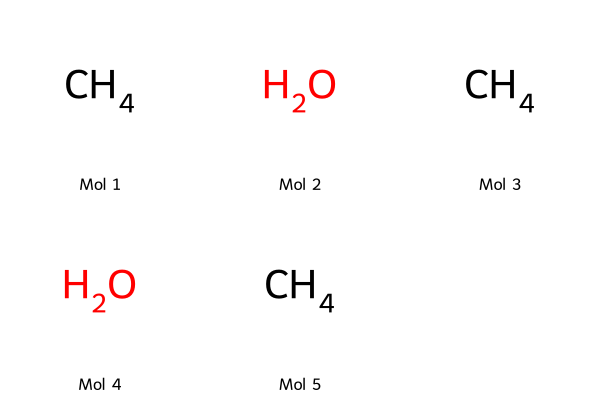

In [11]:
from rdkit import Chem
from rdkit.Chem import Draw
from typing import List, Optional, Tuple
import logging
from PIL import Image
import io
from IPython.display import display

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def visualize_molecules(smiles_list: List[str], n: int = 5, filename: str = "generated_molecules.png") -> Optional[Tuple[str, Image.Image]]:
    """
    Visualize a list of generated molecules from their SMILES strings, save and return the image.

    This function takes the list of generated SMILES strings, converts them to RDKit molecule objects,
    generates a grid image of the molecules, and both saves and returns the image.

    Args:
        smiles_list (List[str]): The list of generated SMILES strings to visualize.
        n (int, optional): Maximum number of molecules to visualize. Defaults to 5.
        filename (str, optional): Name of the file to save the image. Defaults to "generated_molecules.png".

    Returns:
        Optional[Tuple[str, Image.Image]]: A tuple containing the filename of the saved image and the Image object if successful, None otherwise.

    Raises:
        ValueError: If no valid molecules are found in the input list.
    """
    valid_mols = []
    invalid_count = 0
    for i, smiles in enumerate(smiles_list):
        # Remove any start/end tokens and whitespace
        smiles = smiles.strip().strip('<>').strip()
        if not smiles:  # Skip empty strings
            invalid_count += 1
            continue
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                valid_mols.append(mol)
                if len(valid_mols) == n:
                    break
            else:
                logger.warning(f"Invalid SMILES at index {i}: {smiles}")
                invalid_count += 1
        except Exception as e:
            logger.error(f"Error processing SMILES at index {i}: {smiles}. Error: {str(e)}")
            invalid_count += 1

    if not valid_mols:
        logger.error("No valid molecules found in the generated SMILES list.")
        return None

    print(f"{invalid_count} molecules not drawn due to invalidity. Drawing {len(valid_mols)} molecules...")

    try:
        img = Draw.MolsToGridImage(
            valid_mols,
            molsPerRow=min(3, len(valid_mols)),
            subImgSize=(200, 200),
            legends=[f"Mol {i+1}" for i in range(len(valid_mols))]
        )
        # Convert the RDKit image to a PIL Image
        img_pil = Image.open(io.BytesIO(img.data))
        img_pil.save(filename)
        logger.info(f"Generated molecule images saved as '{filename}'")
        return filename, img_pil
    except Exception as e:
        logger.error(f"Error saving generated molecule image: {str(e)}")
        return None

# The function call and display code
result = visualize_molecules(smiles)

if result:
    filename, img = result
    print(f"Visualization of generated molecules successful. Image saved as: {filename}")
    display(img)
else:
    print("Visualization of generated molecules failed.")

The model is a Generative Adversarial Network (GAN) that generates molecular structures in the form of SMILES (Simplified Molecular Input Line Entry System) strings. The model consists of two main components: a generator and a discriminator.

The generator takes a latent vector as input and generates a sequence of tokens representing a SMILES string. The discriminator takes a SMILES string as input and outputs a probability that the string was generated by the real data distribution rather than the generator.

The generator and discriminator are trained together using a two-step process. In the first step, the discriminator is trained to distinguish between real and fake SMILES strings. In the second step, the generator is trained to generate SMILES strings that are indistinguishable from real SMILES strings by maximizing the reward function, which is the difference between the discriminator's output for the generated string and the baseline reward.

The training process involves the following steps:

1. Sample a batch of real SMILES strings from the training data.
2. Sample a batch of latent vectors from the latent space.
3. Generate a batch of fake SMILES strings using the generator and the latent vectors.
4. Train the discriminator to distinguish between real and fake SMILES strings.
5. Train the generator to generate SMILES strings that are indistinguishable from real SMILES strings by maximizing the reward function.
6. Repeat steps 2-5 for a specified number of training steps.

After training, the generator can be used to generate new molecular structures by sampling latent vectors from the latent space and passing them through the generator. The output of the generator is a sequence of tokens representing a SMILES string, which can be converted to a molecular structure using a chemical library such as RDKit.

In the code below, the `MolGen` class is used to train the GAN on a dataset of molecular structures in SMILES format. The `generate_n` method of the `MolGen` class can be used to generate a specified number of new molecular structures, and the `Chem.MolFromSmiles` function from the RDKit library can be used to convert the generated SMILES strings to molecular structures.

# Dataset

In [12]:
import pandas as pd
df = pd.read_csv("/kaggle/input/qm9dataset/qm9.csv")

In [13]:
df.head()

,mol_id,smiles,A,B,C,mu,alpha,homo,lumo,gap,...,zpve,u0,u298,h298,g298,cv,u0_atom,u298_atom,h298_atom,g298_atom
0,gdb_1,C,157.71180,157.709970,157.706990,0.0000,13.21,-0.3877,0.1171,0.5048,...,0.044749,-40.478930,-40.476062,-40.475117,-40.498597,6.469,-395.999595,-398.643290,-401.014647,-372.471772
1,gdb_2,N,293.60975,293.541110,191.393970,1.6256,9.46,-0.2570,0.0829,0.3399,...,0.034358,-56.525887,-56.523026,-56.522082,-56.544961,6.316,-276.861363,-278.620271,-280.399259,-259.338802
2,gdb_3,O,799.58812,437.903860,282.945450,1.8511,6.31,-0.2928,0.0687,0.3615,...,0.021375,-76.404702,-76.401867,-76.400922,-76.422349,6.002,-213.087624,-213.974294,-215.159658,-201.407171
3,gdb_4,C#C,0.00000,35.610036,35.610036,0.0000,16.28,-0.2845,0.0506,0.3351,...,0.026841,-77.308427,-77.305527,-77.304583,-77.327429,8.574,-385.501997,-387.237686,-389.016047,-365.800724
4,gdb_5,C#N,0.00000,44.593883,44.593883,2.8937,12.99,-0.3604,0.0191,0.3796,...,0.016601,-93.411888,-93.409370,-93.408425,-93.431246,6.278,-301.820534,-302.906752,-304.091489,-288.720028


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133885 entries, 0 to 133884
Data columns (total 21 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   mol_id     133885 non-null  object 
 1   smiles     133885 non-null  object 
 2   A          133885 non-null  float64
 3   B          133885 non-null  float64
 4   C          133885 non-null  float64
 5   mu         133885 non-null  float64
 6   alpha      133885 non-null  float64
 7   homo       133885 non-null  float64
 8   lumo       133885 non-null  float64
 9   gap        133885 non-null  float64
 10  r2         133885 non-null  float64
 11  zpve       133885 non-null  float64
 12  u0         133885 non-null  float64
 13  u298       133885 non-null  float64
 14  h298       133885 non-null  float64
 15  g298       133885 non-null  float64
 16  cv         133885 non-null  float64
 17  u0_atom    133885 non-null  float64
 18  u298_atom  133885 non-null  float64
 19  h298_atom  133885 non-n

In [23]:
!pip install -r /kaggle/input/requirements-txt/requirement.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.2/248.2 kB 8.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.2/594.2 kB 30.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.2/730.2 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 1.3 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.5 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━

In [24]:
!pip install --upgrade huggingface-hub==0.24.0

  Using cached huggingface_hub-0.24.0-py3-none-any.whl.metadata (13 kB)
Using cached huggingface_hub-0.24.0-py3-none-any.whl (419 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.10.1
    Uninstalling huggingface-hub-0.10.1:
      Successfully uninstalled huggingface-hub-0.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cached-path 1.1.6 requires huggingface-hub<0.11.0,>=0.8.1, but you have huggingface-hub 0.24.0 which is incompatible.


In [25]:
import huggingface_hub
print(huggingface_hub.__version__)

0.24.0


# Loading Data and Initializing

# Generating Smiles

The none in `mol_list` indicates that it is not valid.

In [26]:
# layers.py

import torch
from allennlp.modules.feedforward import FeedForward
from allennlp.modules.seq2seq_encoders import (LstmSeq2SeqEncoder,
                                               PytorchTransformer)
from torch import nn
from torch.distributions import Categorical
from torch.nn.modules.activation import Sigmoid

class Generator(nn.Module):

    def __init__(self, latent_dim, vocab_size, start_token, end_token):
        """Generator

        Args:
            latent_dim (int): [description]
            vocab_size (int): vocab size without padding
            start_token ([int]): start token (without padding idx)
            end_token ([int]): end token (without padding idx)
        """

        super().__init__()

        # (-1) we do not need pad token for the generator
        self.vocab_size = vocab_size
        self.start_token = start_token
        self.end_token = end_token

        self.embedding_layer = nn.Embedding(self.vocab_size, latent_dim)

        self.project = FeedForward(
            input_dim=latent_dim,
            num_layers=2,
            hidden_dims=[latent_dim * 2, latent_dim * 2],
            activations=[nn.ReLU(), nn.ELU(alpha=0.1)],
            dropout=[0.1, 0.1]
        )

        self.rnn = nn.LSTMCell(latent_dim, latent_dim)

        self.output_layer = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(latent_dim, latent_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(latent_dim * 2, vocab_size - 1)
        )

    def forward(self, z, num_atoms, max_len=20):
        """[summary]

        Args:
            z (torch.Tensor): [description]
            num_atoms (int): number of atoms
            max_len (int, optional): [description]. Defaults to 20.

        Returns:
            dict: x [B, max_len], log_probabilities [B, max_len, vocab], entropies [B,]
        """

        batch_size = z.shape[0]

        # start of sequence
        starts = torch.full(
            size=(batch_size,), fill_value=self.start_token, device=z.device).long()

        # embed_start
        emb = self.embedding_layer(starts)

        x = []
        log_probabilities = []
        entropies = []

        h, c = self.project(z).chunk(2, dim=1)

        for i in range(max_len):

            # new state
            h, c = self.rnn(emb, (h, c))

            # prediction
            logits = self.output_layer(h)

            # create dist
            dist = Categorical(logits=logits)

            # sample
            sample = dist.sample()

            # append prediction
            x.append(sample)

            # append log prob
            log_probabilities.append(dist.log_prob(sample))

            # append entropy
            entropies.append(dist.entropy())

            # new embedding
            emb = self.embedding_layer(sample)

        # stack along sequence dim
        x = torch.stack(x, dim=1)
        log_probabilities = torch.stack(log_probabilities, dim=1)
        entropies = torch.stack(entropies, dim=1)

        # keep only valid lengths (before EOS)
        end_pos = (x == self.end_token).float().argmax(dim=1).cpu()

        # sequence length is end token position + 1
        seq_lengths = end_pos + 1

        # if end_pos = 0 => put seq_length = max_len
        seq_lengths.masked_fill_(seq_lengths == 1, max_len)

        # select up to length
        _x = []
        _log_probabilities = []
        _entropies = []
        for x_i, logp, ent, length in zip(x, log_probabilities, entropies, seq_lengths):
            _x.append(x_i[:length])
            _log_probabilities.append(logp[:length])
            _entropies.append(ent[:length].mean())

        x = torch.nn.utils.rnn.pad_sequence(
            _x, batch_first=True, padding_value=-1)

        x = x + 1  # add padding token

        return {'x': x, 'log_probabilities': _log_probabilities, 'entropies': _entropies}

class RecurrentDiscriminator(nn.Module):

    def __init__(self, hidden_size, vocab_size, start_token, bidirectional=True):
        """Reccurent discriminator

        Args:
            hidden_size (int): model hidden size
            vocab_size (int): vocabulary size
            bidirectional (bool, optional): [description]. Defaults to True.
        """

        super().__init__()

        self.start_token = start_token

        self.embedding = nn.Embedding(vocab_size, hidden_size, padding_idx=0)

        self.rnn = LstmSeq2SeqEncoder(
            hidden_size, hidden_size, num_layers=1, bidirectional=bidirectional)

        if bidirectional:
            hidden_size = hidden_size * 2

        self.fc = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size * 2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        """[summary]

        Args:
            x ([type]): [description]

        Returns:
            [type]: [description]
        """

        batch_size, _ = x.size()

        # append start token to the input
        starts = torch.full(
            size=(batch_size, 1), fill_value=self.start_token, device=x.device).long()

        x = torch.cat([starts, x], dim=1)

        mask = x > 0

        # embed input [batch_size, max_len, hidden_size]
        emb = self.embedding(x)

        # contextualize representation
        x = self.rnn(emb, mask)

        # prediction for each sequence
        out = self.fc(x).squeeze(-1)  # [B, max_len]

        return {'out': out[:, 1:], 'mask': mask.float()[:, 1:]}

# tokenizer.py

import torch

class Tokenizer(object):

    def __init__(self, data):

        unique_char = list(set(''.join(data))) + ['<eos>'] + ['<sos>']

        self.mapping = {'<pad>': 0}

        for i, c in enumerate(unique_char, start=1):
            self.mapping[c] = i

        self.inv_mapping = {v: k for k, v in self.mapping.items()}

        self.start_token = self.mapping['<sos>']

        self.end_token = self.mapping['<eos>']

        self.vocab_size = len(self.mapping.keys())

    def encode_smile(self, mol, add_eos=True):

        out = [self.mapping[i] for i in mol]

        if add_eos:
            out = out + [self.end_token]

        return torch.LongTensor(out)

    def batch_tokenize(self, batch):

        out = map(lambda x: self.encode_smile(x), batch)

        return torch.nn.utils.rnn.pad_sequence(list(out), batch_first=True)


/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warn(f"Failed to load image Python extension: {e}")
/opt/conda/lib/python3.10/site-packages/fairscale/experimental/nn/offload.py:19: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  return torch.cuda.amp.custom_fwd(orig_func)  # type: ignore
/opt/conda/lib/python3.10/site-packages/fairscale/experimental/nn/offload.py:30: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  return torch.cuda.amp.custom_bwd(orig_func)  # type: ignore


In [27]:
# model.py

import numpy as np
import torch
import torch.nn.functional as F
from rdkit import Chem, RDLogger
from torch import nn
from torch.nn.utils import clip_grad_value_
from torch.utils.data import DataLoader


RDLogger.DisableLog('rdApp.*')

class MolGen(nn.Module):

    def __init__(self, data, hidden_dim=128, lr=1e-3, device='cpu'):
        """[summary]

        Args:
            data (list[str]): [description]
            hidden_dim (int, optional): [description]. Defaults to 128.
            lr ([type], optional): learning rate. Defaults to 1e-3.
            device (str, optional): 'cuda' or 'cpu'. Defaults to 'cpu'.
        """
        super().__init__()

        self.device = device

        self.hidden_dim = hidden_dim

        self.tokenizer = Tokenizer(data)

        self.generator = Generator(
            latent_dim=hidden_dim,
            vocab_size=self.tokenizer.vocab_size - 1,
            start_token=self.tokenizer.start_token - 1,  # no need token
            end_token=self.tokenizer.end_token - 1,
        ).to(device)

        self.discriminator = RecurrentDiscriminator(
            hidden_size=hidden_dim,
            vocab_size=self.tokenizer.vocab_size,
            start_token=self.tokenizer.start_token,
            bidirectional=True
        ).to(device)

        self.generator_optim = torch.optim.Adam(
            self.generator.parameters(), lr=lr)

        self.discriminator_optim = torch.optim.Adam(
            self.discriminator.parameters(), lr=lr)

        self.b = 0.  # baseline reward

    def sample_latent(self, batch_size):
        """Sample from latent space

        Args:
            batch_size (int): number of samples

        Returns:
            torch.Tensor: [batch_size, self.hidden_dim]
        """
        return torch.randn(batch_size, self.hidden_dim).to(self.device)

    def discriminator_loss(self, x, y):
        """Discriminator loss

        Args:
            x (torch.LongTensor): input sequence [batch_size, max_len]
            y (torch.LongTensor): sequence label (zeros from generatoe, ones from real data)
                                  [batch_size, max_len]

        Returns:
            loss value
        """

        y_pred, mask = self.discriminator(x).values()

        loss = F.binary_cross_entropy(
            y_pred, y, reduction='none') * mask

        loss = loss.sum() / mask.sum()

        return loss

    def train_step(self, x, num_atoms):
        """One training step

        Args:
            x (torch.LongTensor): sample form real distribution
            num_atoms (int): number of atoms
        """

        batch_size, len_real = x.size()

        # create real and fake labels
        x_real = x.to(self.device)
        y_real = torch.ones(batch_size, len_real).to(self.device)

        # sample latent var
        z = self.sample_latent(batch_size)
        generator_outputs = self.generator.forward(z, num_atoms, max_len=20)
        x_gen, log_probs, entropies = generator_outputs.values()

        # label for fake data
        _, len_gen = x_gen.size()
        y_gen = torch.zeros(batch_size, len_gen).to(self.device)

        #####################
        # Train Discriminator
        #####################

        self.discriminator_optim.zero_grad()

        # disc fake loss
        fake_loss = self.discriminator_loss(x_gen, y_gen)

        # disc real loss
        real_loss = self.discriminator_loss(x_real, y_real)

        # combined loss
        discr_loss = 0.5 * (real_loss + fake_loss)
        discr_loss.backward()

        # clip grad
        clip_grad_value_(self.discriminator.parameters(), 0.1)

        # update params
        self.discriminator_optim.step()

        # ###############
        # Train Generator
        # ###############

        self.generator_optim.zero_grad()

        # prediction for generated x
        y_pred, y_pred_mask = self.discriminator(x_gen).values()

        # Reward (see the ref paper)
        R = (2 * y_pred - 1)

        # reward len for each sequence
        lengths = y_pred_mask.sum(1).long()

        # list of rew of each sequences
        list_rewards = [rw[:ln] for rw, ln in zip(R, lengths)]

        # compute - (r - b) log x
        generator_loss = []
        for reward, log_p in zip(list_rewards, log_probs):

            # substract the baseline
            reward_baseline = reward - self.b

            generator_loss.append((- reward_baseline * log_p).sum())

        # mean loss + entropy reg
        generator_loss = torch.stack(generator_loss).mean() - \
            sum(entropies) * 0.01 / batch_size

        # baseline moving average
        with torch.no_grad():
            mean_reward = (R * y_pred_mask).sum() / y_pred_mask.sum()
            self.b = 0.9 * self.b + (1 - 0.9) * mean_reward

        generator_loss.backward()

        clip_grad_value_(self.generator.parameters(), 0.1)

        self.generator_optim.step()

        return {'loss_disc': discr_loss.item(), 'mean_reward': mean_reward}

    def create_dataloader(self, data, batch_size=128, shuffle=True, num_workers=5):
        """create a dataloader

        Args:
            data (list[str]): list of molecule smiles
            batch_size (int, optional): Defaults to 128.
            shuffle (bool, optional): Defaults to True.
            num_workers (int, optional): Defaults to 5.

        Returns:
            torch.data.DataLoader: a torch dataloader
        """

        return DataLoader(
            data,
            batch_size=batch_size,
            shuffle=shuffle,
            collate_fn=self.tokenizer.batch_tokenize,
            num_workers=num_workers
        )

    def train_n_steps(self, train_loader, max_step=10000, evaluate_every=50):
        """Train for max_step steps

        Args:
            train_loader (torch.data.DataLoader): dataloader
            max_step (int, optional): Defaults to 10000.
            evaluate_every (int, optional): Defaults to 50.
        """

        iter_loader = iter(train_loader)

        # best_score = 0.0

        for step in range(max_step):

            try:
                batch = next(iter_loader)
            except:
                iter_loader = iter(train_loader)
                batch = next(iter_loader)

            # model update
            self.train_step(batch, num_atoms=10)  # specify the number of atoms

            if step % evaluate_every == 0:

                self.eval()
                score = self.evaluate_n(100)
                self.train()

                # if score > best_score:
                #     self.save_best()
                #     print('saving')
                #     best_score = score

                print(f'valid = {score: .2f}')

    def get_mapped(self, seq):
        """Transform a sequence of ids to string

        Args:
            seq (list[int]): sequence of ids

        Returns:
            str: string output
        """
        return ''.join([self.tokenizer.inv_mapping[i] for i in seq])

    @torch.no_grad()
    def generate_n(self, n, num_atoms):
        """Generate n molecules

        Args:
            n (int)
            num_atoms (int): number of atoms

        Returns:
            list[str]: generated molecules
        """

        z = torch.randn((n, self.hidden_dim)).to(self.device)

        x = self.generator(z, num_atoms)['x'].cpu()

        lengths = (x > 0).sum(1)

        # l - 1 because we exclude end tokens
        return [self.get_mapped(x[:l-1].numpy()) for x, l in zip(x, lengths)]

    def evaluate_n(self, n):
        """Evaluation: frequence of valid molecules using rdkit

        Args:
            n (int): number of sample

        Returns:
            float: requence of valid molecules
        """

        pack = self.generate_n(n, num_atoms=10)  # specify the number of atoms

        print(pack[:2])

        valid = np.array([Chem.MolFromSmiles(k) is not None for k in pack])

        return valid.mean()

[')F', 'cc1N1)(n']
valid =  0.01
['C)=((COOCO((CcCncOO', '=((1']
valid =  0.02
['C11C-1', 'CF']
valid =  0.20
['CcC1CO1C(C=', 'CC)OC']
valid =  0.09
['CC1C2C-C2C1Cn1ON)CO', 'COCC1CCO3C=']
valid =  0.06
['CCCC1CCCC#OC3CC1CO', 'CC1CC1CC1C2C']
valid =  0.08
['OC1', 'C1CC)CnC2']
valid =  0.09
['CCN1CCO=CC(C#N', 'OC1CCCCOCO2O']
valid =  0.08
['OC12CC1CC2O', 'ON1CC2C2O']
valid =  0.11
['COC1CCC1C(C1OOC=C3', 'COC2C1OC1OC1C3COC1']
valid =  0.07
['CC1COCC2CC2O', 'CCOC1CCOO']
valid =  0.17
['COCC1CC1OCCC1CC1CC1', 'NC1C=CC2CCCC1C=N=N']
valid =  0.05
['CC#CCNC1COC1', 'CNC1C2CCC2C1N']
valid =  0.10
['CC1CCO', 'CC12CCC1']
valid =  0.19
['CC1COC2CO', 'CC#CC12CC#CC1(']
valid =  0.14
['CC1CC12CO', 'OC1C1C2C']
valid =  0.22
['CCC1COC22', 'CC1COCC22CC1C1O']
valid =  0.10
['C1C#CCOC1OC', 'CC1C2CC1NC2']
valid =  0.14
['CCC1C2COC1C=', 'CC12CCC1C3C=COCO2']
valid =  0.19
['CC1=COC1C12', 'O=CC1CO2CC2CC11O']
valid =  0.16
['C1COC1CN12', 'CC12CCC#N']
valid =  0.15
['OC1CC2CC12NC1C2O', 'N=CC1CCOC2O']
valid =  0.2

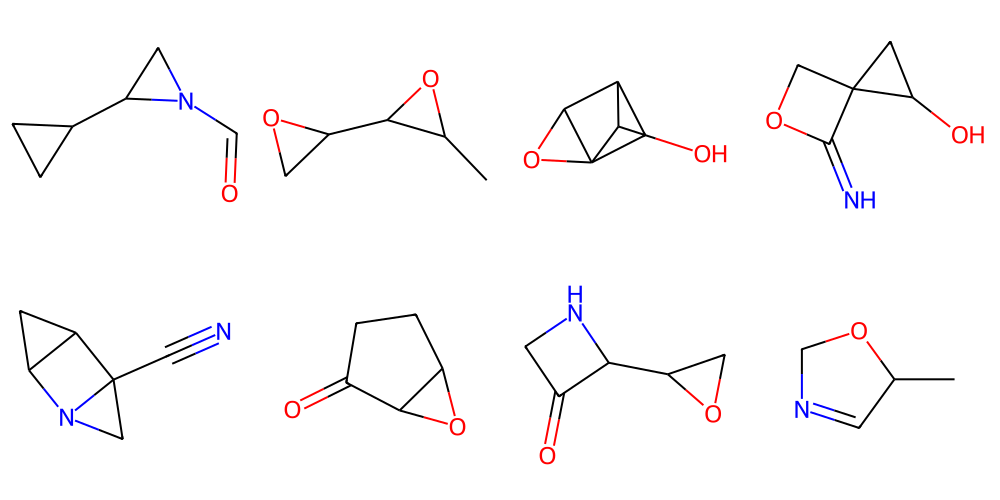

In [28]:
# train.py

from rdkit import Chem

# load data
data = []
with open('/kaggle/input/qm9dataset/qm9.csv', "r") as f:
    for line in f.readlines()[1:]:
        data.append(line.split(",")[1])

# create model
gan_mol = MolGen(data, hidden_dim=64, lr=1e-3, device="cuda")
# create dataloader
loader = gan_mol.create_dataloader(data, batch_size=128, shuffle=True, num_workers=0)

# train model for 10000 steps
gan_mol.train_n_steps(loader, max_step=20000, evaluate_every=100)
gan_mol.eval()

print('ok')
# After training
# generate Smiles molecules with a specific number of atoms
num_atoms = 10  # specify the number of atoms
smiles_list = gan_mol.generate_n(8, num_atoms)

# convert with rdkit
mol_list = [Chem.MolFromSmiles(m) for m in smiles_list]

# draw
Chem.Draw.MolsToGridImage(mol_list, molsPerRow=4, subImgSize=(250, 250), maxMols=10)

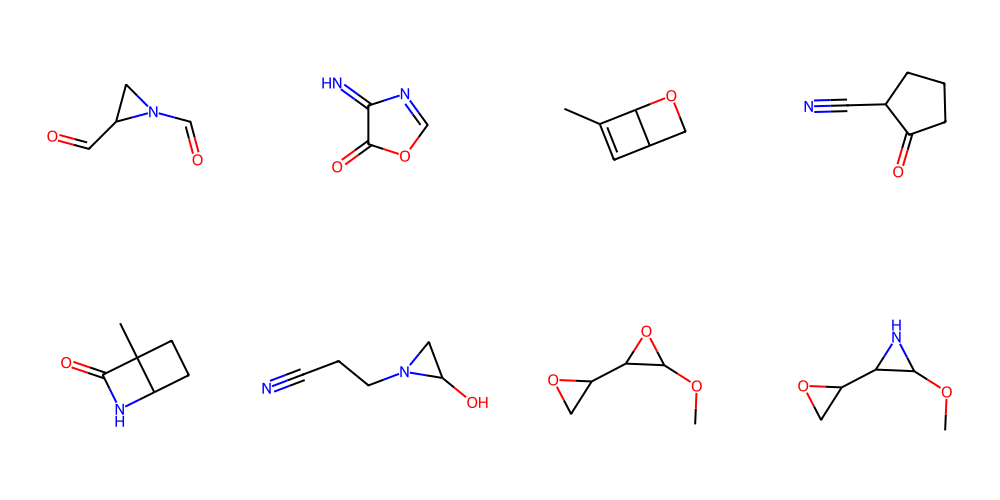

In [29]:
num_atoms = 25  # specify the number of atoms
smiles_list = gan_mol.generate_n(8, num_atoms)

# convert with rdkit
mol_list = [Chem.MolFromSmiles(m) for m in smiles_list]

# draw
Chem.Draw.MolsToGridImage(mol_list, molsPerRow=4, subImgSize=(250, 250), maxMols=10)


In [30]:
import pandas as pd
from rdkit import Chem

# Assuming 'smiles_list' contains the SMILES strings and 'mol_list' contains RDKit molecules
data = []

for smiles, mol in zip(smiles_list, mol_list):
    if mol:  # Check if the molecule is valid
        mol_with_h = Chem.AddHs(mol)  # Add explicit hydrogens
        num_atoms = mol_with_h.GetNumAtoms()
        data.append({'SMILES': smiles, 'NumAtoms': num_atoms})
    else:
        data.append({'SMILES': smiles, 'NumAtoms': None})  # Handle invalid molecules

# Create a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)


          SMILES  NumAtoms
0    O=CN1CC1C=O        12
1   O=C1OC=NC1=N         9
2   CC1=CC2COC12        15
3   O=C1CCCC1C#N        15
4  O=C1NC2CCC12C        17
5    OC1CN1CCC#N        16
6   COC1OC1C1CO1        16
7   COC1NC1C1CO1        17


# Saving and loading model

In [31]:
# Save model
import torch
torch.save(gan_mol.state_dict(), 'gan_mol_dict.pth')


In [32]:
# Load model
# load data
data = []
with open('/kaggle/input/qm9dataset/qm9.csv', "r") as f:
    for line in f.readlines()[1:]:
        data.append(line.split(",")[1])

gan_mol_n = MolGen(data, hidden_dim=64, lr=1e-3, device="cuda")

# Load the state dictionary into the new model
gan_mol_n.load_state_dict(torch.load('gan_mol_dict.pth'))

# Print the loaded model state to verify
# print("Loaded model state:", gan_mol_n.state_dict())

/tmp/ipykernel_30/461943297.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gan_mol_n.load_state_dict(torch.load('gan_mol_dict.pth'))


<All keys matched successfully>

In [33]:
gan_mol_n.eval()

print('ok')

ok


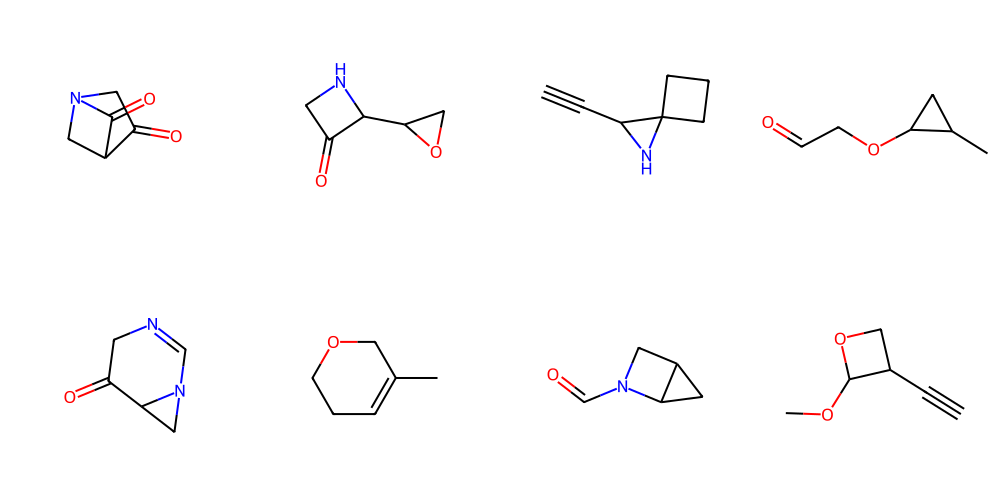

In [34]:
num_atoms = 25  # specify the number of atoms
smiles_list = gan_mol.generate_n(8, num_atoms)

# convert with rdkit
mol_list = [Chem.MolFromSmiles(m) for m in smiles_list]

# draw
Chem.Draw.MolsToGridImage(mol_list, molsPerRow=4, subImgSize=(250, 250), maxMols=10)


EVALUATIONS 

For the VAE Model
python
Copy code


In [36]:
# Number of samples to generate
num_samples = 1000

# Generate SMILES strings using the trained VAE model
vae_generated_smiles = generate_smiles(model, vocab, num_samples=num_samples)

# Post-process and validate the generated SMILES strings
vae_smiles = []
for smiles in vae_generated_smiles:
    processed_smiles = enhanced_post_process_smiles(smiles)
    is_valid, corrected_smiles = validate_and_correct_smiles(processed_smiles)
    if is_valid:
        vae_smiles.append(corrected_smiles)


In [37]:
#FOR GAN 
# Number of samples to generate
num_samples = 1000

# Generate SMILES strings using the trained GAN model
num_atoms = 10  # You can adjust this based on your preference
gan_generated_smiles = gan_mol.generate_n(num_samples, num_atoms)

# Post-process and validate the generated SMILES strings
gan_smiles = []
for smiles in gan_generated_smiles:
    processed_smiles = enhanced_post_process_smiles(smiles)
    is_valid, corrected_smiles = validate_and_correct_smiles(processed_smiles)
    if is_valid:
        gan_smiles.append(corrected_smiles)


In [38]:
def compute_metrics(generated_smiles: List[str], training_smiles: Set[str]) -> Dict[str, float]:
    """
    Compute validity, uniqueness, and novelty metrics.

    Args:
        generated_smiles (List[str]): List of generated SMILES strings.
        training_smiles (Set[str]): Set of training SMILES strings.

    Returns:
        Dict[str, float]: Dictionary with metrics.
    """
    total = len(generated_smiles)
    valid_smiles = []
    unique_smiles = set()
    novel_smiles = set()

    for smiles in generated_smiles:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            valid_smiles.append(smiles)
            unique_smiles.add(smiles)
            if smiles not in training_smiles:
                novel_smiles.add(smiles)

    validity = len(valid_smiles) / total * 100 if total > 0 else 0
    uniqueness = len(unique_smiles) / len(valid_smiles) * 100 if len(valid_smiles) > 0 else 0
    novelty = len(novel_smiles) / len(valid_smiles) * 100 if len(valid_smiles) > 0 else 0

    return {
        'total': total,
        'valid': len(valid_smiles),
        'unique': len(unique_smiles),
        'novel': len(novel_smiles),
        'validity_rate': validity,
        'uniqueness_rate': uniqueness,
        'novelty_rate': novelty
    }


In [39]:
# Convert training SMILES list to a set for faster lookup
training_smiles_set = set(smiles_list)

# Compute metrics for VAE
vae_metrics = compute_metrics(vae_smiles, training_smiles_set)

# Compute metrics for GAN
gan_metrics = compute_metrics(gan_smiles, training_smiles_set)


In [40]:
def calculate_properties_list(smiles_list: List[str]) -> pd.DataFrame:
    """
    Calculate properties for a list of SMILES strings.

    Args:
        smiles_list (List[str]): List of SMILES strings.

    Returns:
        pd.DataFrame: DataFrame containing properties.
    """
    properties = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            props = {
                'SMILES': smiles,
                'MolWt': Descriptors.ExactMolWt(mol),
                'LogP': Descriptors.MolLogP(mol),
                'NumHDonors': Descriptors.NumHDonors(mol),
                'NumHAcceptors': Descriptors.NumHAcceptors(mol)
            }
            properties.append(props)
    return pd.DataFrame(properties)


In [41]:
# Calculate properties for VAE-generated molecules
vae_properties_df = calculate_properties_list(vae_smiles)

# Calculate properties for GAN-generated molecules
gan_properties_df = calculate_properties_list(gan_smiles)

# Calculate properties for training data for comparison
training_properties_df = calculate_properties_list(smiles_list)


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')


In [43]:
def plot_property_distributions(property_name: str, vae_df: pd.DataFrame, gan_df: pd.DataFrame, training_df: pd.DataFrame):
    """
    Plot histograms of a given molecular property for VAE, GAN, and training data.

    Args:
        property_name (str): Name of the property to plot.
        vae_df (pd.DataFrame): DataFrame of VAE-generated molecule properties.
        gan_df (pd.DataFrame): DataFrame of GAN-generated molecule properties.
        training_df (pd.DataFrame): DataFrame of training molecule properties.
    """
    plt.figure(figsize=(12, 6))
    sns.histplot(training_df[property_name], color='green', label='Training Data', kde=False, stat='density', bins=50, alpha=0.5)
    sns.histplot(vae_df[property_name], color='blue', label='VAE', kde=False, stat='density', bins=50, alpha=0.5)
    sns.histplot(gan_df[property_name], color='red', label='GAN', kde=False, stat='density', bins=50, alpha=0.5)
    plt.legend()
    plt.xlabel(property_name)
    plt.ylabel('Density')
    plt.title(f'Distribution of {property_name}')
    plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


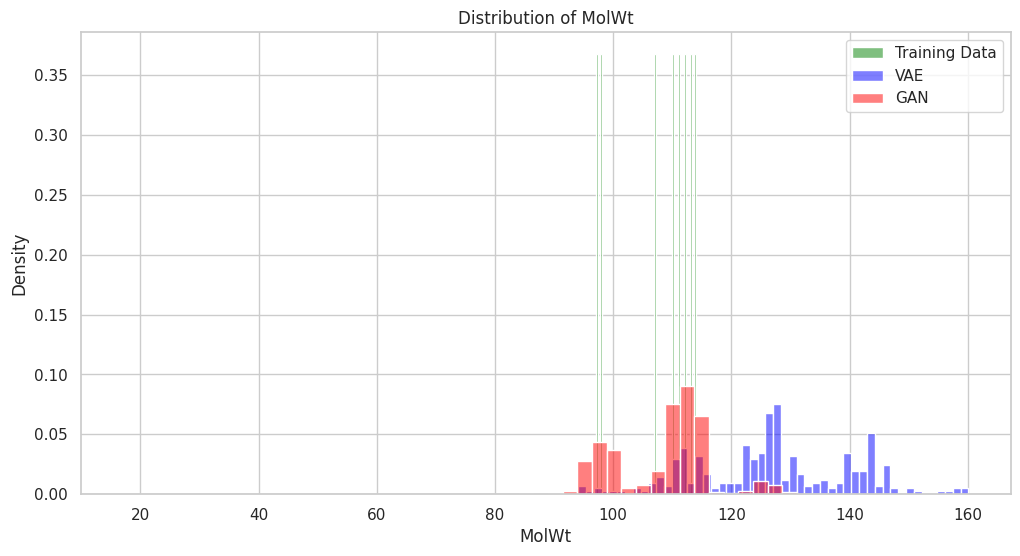

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


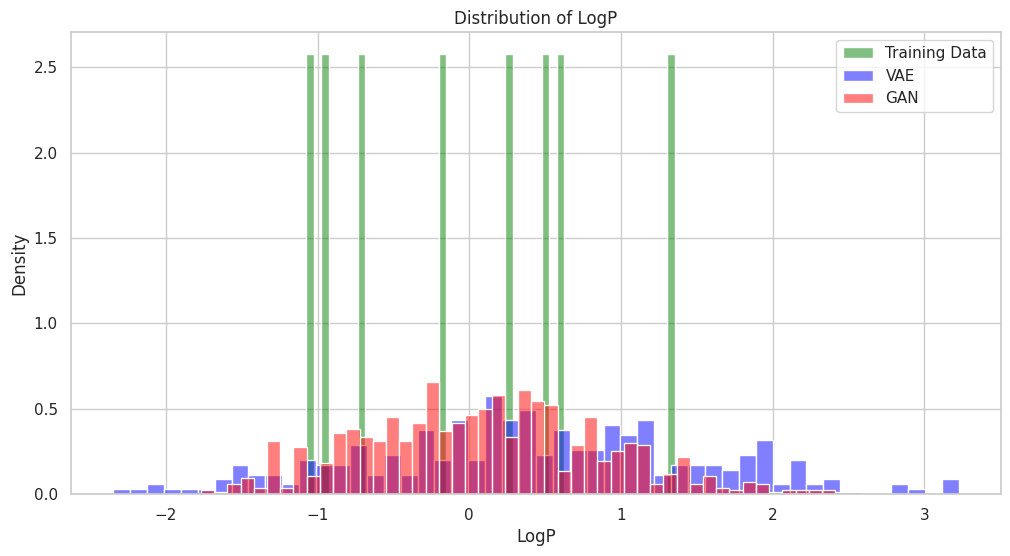

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


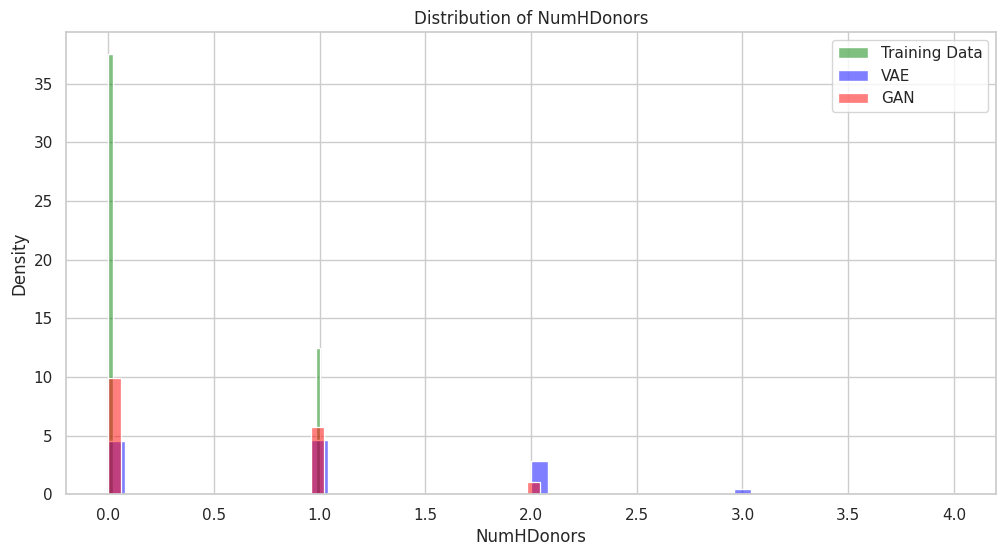

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


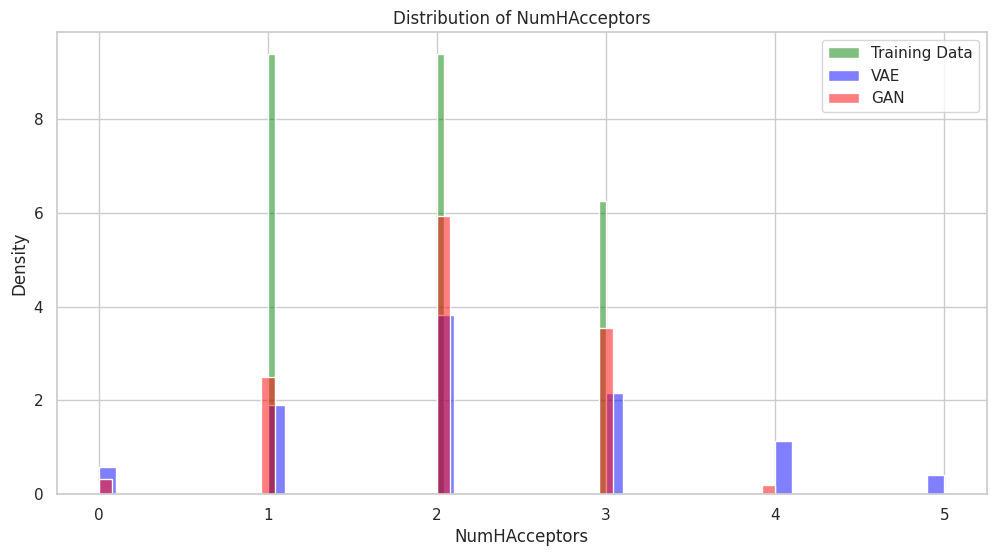

In [44]:
# Molecular Weight
plot_property_distributions('MolWt', vae_properties_df, gan_properties_df, training_properties_df)

# LogP
plot_property_distributions('LogP', vae_properties_df, gan_properties_df, training_properties_df)

# Number of Hydrogen Bond Donors
plot_property_distributions('NumHDonors', vae_properties_df, gan_properties_df, training_properties_df)

# Number of Hydrogen Bond Acceptors
plot_property_distributions('NumHAcceptors', vae_properties_df, gan_properties_df, training_properties_df)


In [45]:
metrics_df = pd.DataFrame({
    'Model': ['VAE', 'GAN'],
    'Validity Rate (%)': [vae_metrics['validity_rate'], gan_metrics['validity_rate']],
    'Uniqueness Rate (%)': [vae_metrics['uniqueness_rate'], gan_metrics['uniqueness_rate']],
    'Novelty Rate (%)': [vae_metrics['novelty_rate'], gan_metrics['novelty_rate']],
    'Average MolWt': [vae_properties_df['MolWt'].mean(), gan_properties_df['MolWt'].mean()],
    'Average LogP': [vae_properties_df['LogP'].mean(), gan_properties_df['LogP'].mean()],
    'Average NumHDonors': [vae_properties_df['NumHDonors'].mean(), gan_properties_df['NumHDonors'].mean()],
    'Average NumHAcceptors': [vae_properties_df['NumHAcceptors'].mean(), gan_properties_df['NumHAcceptors'].mean()]
})

print(metrics_df)


  Model  Validity Rate (%)  Uniqueness Rate (%)  Novelty Rate (%)  \
0   VAE              100.0            99.678457         99.678457   
1   GAN              100.0            75.327291         74.924471   

   Average MolWt  Average LogP  Average NumHDonors  Average NumHAcceptors  
0     126.964591      0.412768            0.967846                2.26045  
1     108.390600      0.088263            0.473313                2.06143  


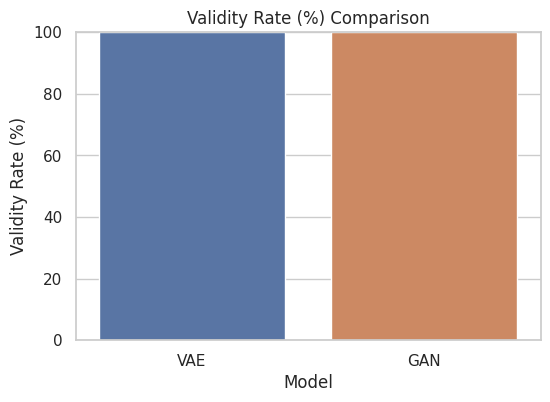

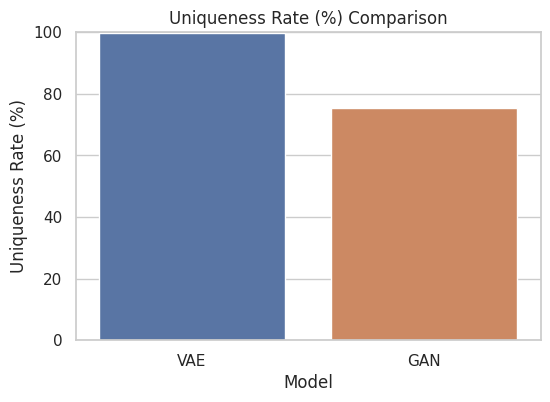

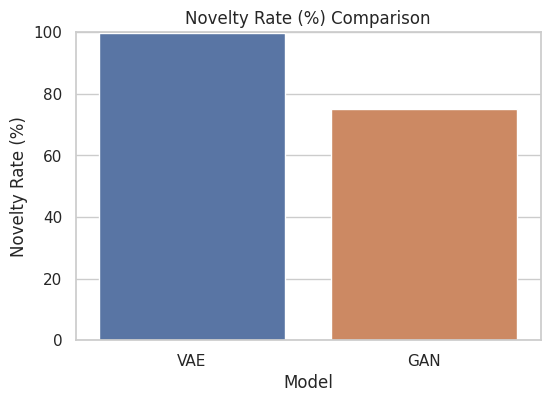

In [46]:
# Plotting Validity, Uniqueness, and Novelty Rates

metrics = ['Validity Rate (%)', 'Uniqueness Rate (%)', 'Novelty Rate (%)']

for metric in metrics:
    plt.figure(figsize=(6, 4))
    sns.barplot(x='Model', y=metric, data=metrics_df)
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.ylim(0, 100)
    plt.show()


new

In [47]:
# Number of samples to generate
num_samples = 1000

# Generate and process VAE molecules
vae_generated_smiles = generate_smiles(model, vocab, num_samples=num_samples)
vae_smiles = []
for smiles in vae_generated_smiles:
    processed_smiles = enhanced_post_process_smiles(smiles)
    is_valid, corrected_smiles = validate_and_correct_smiles(processed_smiles)
    if is_valid:
        vae_smiles.append(corrected_smiles)

# Generate and process GAN molecules
gan_generated_smiles = gan_mol.generate_n(num_samples, num_atoms=10)
gan_smiles = []
for smiles in gan_generated_smiles:
    processed_smiles = enhanced_post_process_smiles(smiles)
    is_valid, corrected_smiles = validate_and_correct_smiles(processed_smiles)
    if is_valid:
        gan_smiles.append(corrected_smiles)

# Use real molecules from the training data
real_smiles = smiles_list[:num_samples]  # Adjust as needed


In [48]:
# Combine SMILES strings
combined_smiles = real_smiles + vae_smiles + gan_smiles

# Create labels: 1 for real, 0 for generated
labels = [1] * len(real_smiles) + [0] * (len(vae_smiles) + len(gan_smiles))


In [49]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import numpy as np

def featurize_molecules(smiles_list):
    fingerprints = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
            arr = np.zeros((1,), dtype=int)
            DataStructs.ConvertToNumpyArray(fp, arr)
            fingerprints.append(arr)
        else:
            fingerprints.append(np.zeros(2048, dtype=int))  # Handle invalid molecules
    return np.array(fingerprints)

# Featurize molecules
X = featurize_molecules(combined_smiles)
y = np.array(labels)


In [50]:
from sklearn.model_selection import train_test_split

# Stratify to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [51]:
from sklearn.ensemble import RandomForestClassifier

# Initialize classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [52]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

# Make predictions
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
report = classification_report(y_test, y_pred)

# Display results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
print("Classification Report:\n", report)


Accuracy: 0.9923664122137404
F1 Score: 0.0
ROC AUC Score: 0.4230769230769231
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       260
           1       0.00      0.00      0.00         2

    accuracy                           0.99       262
   macro avg       0.50      0.50      0.50       262
weighted avg       0.98      0.99      0.99       262



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
# Function to calculate properties
def calculate_properties_list(smiles_list):
    properties = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            props = {
                'MolWt': Descriptors.ExactMolWt(mol),
                'LogP': Descriptors.MolLogP(mol),
                'NumHDonors': Descriptors.NumHDonors(mol),
                'NumHAcceptors': Descriptors.NumHAcceptors(mol)
            }
            properties.append(props)
    return pd.DataFrame(properties)

# Real molecules
real_props_df = calculate_properties_list(real_smiles)
real_mean_props = real_props_df.mean()

# VAE molecules
vae_props_df = calculate_properties_list(vae_smiles)
vae_mean_props = vae_props_df.mean()

# GAN molecules
gan_props_df = calculate_properties_list(gan_smiles)
gan_mean_props = gan_props_df.mean()


In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def compute_regression_metrics(real_mean, gen_mean):
    mse = mean_squared_error([real_mean], [gen_mean])
    mae = mean_absolute_error([real_mean], [gen_mean])
    return mse, mae

# Initialize dictionaries
vae_mse = {}
vae_mae = {}
gan_mse = {}
gan_mae = {}

# Properties to compare
properties = ['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors']

# VAE metrics
for prop in properties:
    mse, mae = compute_regression_metrics(real_mean_props[prop], vae_mean_props[prop])
    vae_mse[prop] = mse
    vae_mae[prop] = mae

# GAN metrics
for prop in properties:
    mse, mae = compute_regression_metrics(real_mean_props[prop], gan_mean_props[prop])
    gan_mse[prop] = mse
    gan_mae[prop] = mae

# Display results
print("VAE MSE:", vae_mse)
print("VAE MAE:", vae_mae)
print("GAN MSE:", gan_mse)
print("GAN MAE:", gan_mae)


VAE MSE: {'MolWt': 362.5413561417887, 'LogP': 0.12703027962725152, 'NumHDonors': 0.5384899875367873, 'NumHAcceptors': 0.20711335894052207}
VAE MAE: {'MolWt': 19.04051879917637, 'LogP': 0.356413074433657, 'NumHDonors': 0.7338187702265372, 'NumHAcceptors': 0.45509708737864063}
GAN MSE: {'MolWt': 0.24119156995324548, 'LogP': 0.024589802903263295, 'NumHDonors': 0.04396462018730488, 'NumHAcceptors': 0.024100058532778364}
GAN MAE: {'MolWt': 0.49111258378628975, 'LogP': 0.15681136088709674, 'NumHDonors': 0.2096774193548387, 'NumHAcceptors': 0.155241935483871}


In [70]:
from fcd_torch import FCD
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize FCD calculator
fcd_calculator = FCD(device='cuda:0')  # or 'cpu' if GPU is not available

# Compute FCD for VAE
vae_fcd = fcd_calculator(real_smiles, vae_smiles)
print("VAE Fréchet ChemNet Distance:", vae_fcd)

# Compute FCD for GAN
gan_fcd = fcd_calculator(real_smiles, gan_smiles)
print("GAN Fréchet ChemNet Distance:", gan_fcd)

# Function to compute average Tanimoto similarity
def compute_tanimoto_similarity(real_smiles_list, generated_smiles_list):
    real_fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), 2, nBits=2048) for s in real_smiles_list if Chem.MolFromSmiles(s)]
    gen_fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), 2, nBits=2048) for s in generated_smiles_list if Chem.MolFromSmiles(s)]
    
    similarities = []
    for gen_fp in gen_fps:
        sim = DataStructs.BulkTanimotoSimilarity(gen_fp, real_fps)
        similarities.append(np.mean(sim))
    
    return np.mean(similarities)

# VAE similarity
vae_similarity = compute_tanimoto_similarity(real_smiles, vae_smiles)
print("VAE Average Tanimoto Similarity:", vae_similarity)

# GAN similarity
gan_similarity = compute_tanimoto_similarity(real_smiles, gan_smiles)
print("GAN Average Tanimoto Similarity:", gan_similarity)

# Function to compute internal diversity
def compute_internal_diversity(smiles_list):
    fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), 2, nBits=2048) for s in smiles_list if Chem.MolFromSmiles(s)]
    num_fps = len(fps)
    diversities = []
    for i in range(num_fps):
        for j in range(i+1, num_fps):
            sim = DataStructs.TanimotoSimilarity(fps[i], fps[j])
            diversities.append(1 - sim)
    return np.mean(diversities)

# VAE diversity
vae_diversity = compute_internal_diversity(vae_smiles)
print("VAE Internal Diversity:", vae_diversity)

# GAN diversity
gan_diversity = compute_internal_diversity(gan_smiles)
print("GAN Internal Diversity:", gan_diversity)

# Comparison table
metrics_comparison = pd.DataFrame({
    'Metric': ['FCD', 'Avg Tanimoto Similarity', 'Internal Diversity'],
    'VAE': [vae_fcd, vae_similarity, vae_diversity],
    'GAN': [gan_fcd, gan_similarity, gan_diversity]
})

print(metrics_comparison)

#


/opt/conda/lib/python3.10/site-packages/fcd_torch/fcd.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  keras_config = torch.load(model_path)


VAE Fréchet ChemNet Distance: 47.773514819568476
GAN Fréchet ChemNet Distance: 118.9818854449498
VAE Average Tanimoto Similarity: 0.33522227112676056
GAN Average Tanimoto Similarity: 0.12318840579710146
VAE Internal Diversity: 0.9375
GAN Internal Diversity: 0.32558139534883723
                    Metric        VAE         GAN
0                      FCD  47.773515  118.981885
1  Avg Tanimoto Similarity   0.335222    0.123188
2       Internal Diversity   0.937500    0.325581


saving models

In [72]:
# Save the VAE model's state_dict
torch.save(model.state_dict(), 'vae_model.pth')

# Save the vocabulary used by the VAE
import pickle
with open('vae_vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)


In [73]:
import torch
import pickle

# Load the saved vocabulary
with open('vae_vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)
vocab_size = len(vocab)

# Initialize the model with the same parameters
hidden_dim = 256  # Use the same hidden_dim as before
latent_dim = 64   # Use the same latent_dim as before

model = VAE(vocab_size, hidden_dim, latent_dim)

# Load the saved state_dict
model.load_state_dict(torch.load('vae_model.pth'))
model.to(device)
model.eval()


/tmp/ipykernel_30/1737774100.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('vae_model.pth'))


VAE(
  (encoder): GRU(23, 256, batch_first=True)
  (fc_mu): Linear(in_features=256, out_features=64, bias=True)
  (fc_logvar): Linear(in_features=256, out_features=64, bias=True)
  (decoder): GRU(87, 256, batch_first=True)
  (fc_output): Linear(in_features=256, out_features=23, bias=True)
)

In [74]:
# Save the GAN model's state_dict
torch.save(gan_mol.state_dict(), 'gan_model.pth')

# Save the tokenizer used by the GAN
import pickle
with open('gan_tokenizer.pkl', 'wb') as f:
    pickle.dump(gan_mol.tokenizer, f)


In [75]:
import torch
import pickle

# Load your data (ensure it's the same data used during training)
data = []
with open('/kaggle/input/qm9dataset/qm9.csv', "r") as f:
    for line in f.readlines()[1:]:
        data.append(line.split(",")[1])

# Recreate the MolGen instance
gan_mol = MolGen(data, hidden_dim=64, lr=1e-3, device="cuda")

# Load the saved state_dict
gan_mol.load_state_dict(torch.load('gan_model.pth'))

# Load the tokenizer
with open('gan_tokenizer.pkl', 'rb') as f:
    gan_mol.tokenizer = pickle.load(f)

gan_mol.to(device)
gan_mol.eval()


/tmp/ipykernel_30/2902617897.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gan_mol.load_state_dict(torch.load('gan_model.pth'))


MolGen(
  (generator): Generator(
    (embedding_layer): Embedding(23, 64)
    (project): FeedForward(
      (_activations): ModuleList(
        (0): ReLU()
        (1): ELU(alpha=0.1)
      )
      (_linear_layers): ModuleList(
        (0): Linear(in_features=64, out_features=128, bias=True)
        (1): Linear(in_features=128, out_features=128, bias=True)
      )
      (_dropout): ModuleList(
        (0-1): 2 x Dropout(p=0.1, inplace=False)
      )
    )
    (rnn): LSTMCell(64, 64)
    (output_layer): Sequential(
      (0): ReLU()
      (1): Dropout(p=0.1, inplace=False)
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3): ReLU()
      (4): Dropout(p=0.1, inplace=False)
      (5): Linear(in_features=128, out_features=22, bias=True)
    )
  )
  (discriminator): RecurrentDiscriminator(
    (embedding): Embedding(24, 64, padding_idx=0)
    (rnn): LstmSeq2SeqEncoder(
      (_module): LSTM(64, 64, batch_first=True, bidirectional=True)
    )
    (fc): Sequential(
     

In [76]:
# After your training loop ends
import torch
import pickle

# Save the VAE model's state_dict
torch.save(model.state_dict(), 'vae_model.pth')

# Save the vocabulary
with open('vae_vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)


In [77]:
import torch
import pickle

# Load the vocabulary
with open('vae_vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)
vocab_size = len(vocab)

# Initialize the model with the same parameters
hidden_dim = 256  # Ensure this matches your trained model
latent_dim = 64   # Ensure this matches your trained model

model = VAE(vocab_size, hidden_dim, latent_dim)
model.load_state_dict(torch.load('vae_model.pth'))
model.to(device)
model.eval()


/tmp/ipykernel_30/260694113.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('vae_model.pth'))


VAE(
  (encoder): GRU(23, 256, batch_first=True)
  (fc_mu): Linear(in_features=256, out_features=64, bias=True)
  (fc_logvar): Linear(in_features=256, out_features=64, bias=True)
  (decoder): GRU(87, 256, batch_first=True)
  (fc_output): Linear(in_features=256, out_features=23, bias=True)
)

In [78]:
import torch
import pickle

# Save the GAN model's state_dict
torch.save(gan_mol.state_dict(), 'gan_model.pth')

# Save the tokenizer
with open('gan_tokenizer.pkl', 'wb') as f:
    pickle.dump(gan_mol.tokenizer, f)


In [79]:
import torch
import pickle

# Load your data
data = []
with open('/kaggle/input/qm9dataset/qm9.csv', "r") as f:
    for line in f.readlines()[1:]:
        data.append(line.split(",")[1])

# Initialize the MolGen instance
gan_mol = MolGen(data, hidden_dim=64, lr=1e-3, device="cuda")

# Load the saved state_dict
gan_mol.load_state_dict(torch.load('gan_model.pth'))

# Load the tokenizer
with open('gan_tokenizer.pkl', 'rb') as f:
    gan_mol.tokenizer = pickle.load(f)

gan_mol.to(device)
gan_mol.eval()


/tmp/ipykernel_30/2920367490.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gan_mol.load_state_dict(torch.load('gan_model.pth'))


MolGen(
  (generator): Generator(
    (embedding_layer): Embedding(23, 64)
    (project): FeedForward(
      (_activations): ModuleList(
        (0): ReLU()
        (1): ELU(alpha=0.1)
      )
      (_linear_layers): ModuleList(
        (0): Linear(in_features=64, out_features=128, bias=True)
        (1): Linear(in_features=128, out_features=128, bias=True)
      )
      (_dropout): ModuleList(
        (0-1): 2 x Dropout(p=0.1, inplace=False)
      )
    )
    (rnn): LSTMCell(64, 64)
    (output_layer): Sequential(
      (0): ReLU()
      (1): Dropout(p=0.1, inplace=False)
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3): ReLU()
      (4): Dropout(p=0.1, inplace=False)
      (5): Linear(in_features=128, out_features=22, bias=True)
    )
  )
  (discriminator): RecurrentDiscriminator(
    (embedding): Embedding(24, 64, padding_idx=0)
    (rnn): LstmSeq2SeqEncoder(
      (_module): LSTM(64, 64, batch_first=True, bidirectional=True)
    )
    (fc): Sequential(
     